In [1]:
import matplotlib.pyplot as plt 
import numpy as np 
import os 
import cv2
import random
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D, GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from tensorflow.keras import utils
from tensorflow.keras.callbacks import EarlyStopping
import pandas as pd
import seaborn as sns
import pickle
from sklearn.metrics import confusion_matrix
import itertools

%matplotlib inline

2025-03-14 11:54:26.579576: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-03-14 11:54:26.580225: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-03-14 11:54:26.583158: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-03-14 11:54:26.591253: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1741920866.603596   13127 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1741920866.60

## 필요 기능 함수 선언 

In [2]:
def plot_results(mod_history, metric, epochs):
      
      # Check out our train loss and test loss over epochs.
      train_metric = mod_history.history[metric]
      val = 'val_' + metric
      test_metric = mod_history.history[val]

      # Set figure size.
      plt.figure(figsize=(12, 8))

      # Generate line plot of training, testing loss over epochs.
      plt.plot(train_metric, label=f'Training {metric}', color='#185fad')
      plt.plot(test_metric, label=f'Testing {metric}', color='orange')

      # Set title
      plt.title(f'Training and Testing {metric} by Epoch', fontsize = 25)
      plt.xlabel('Epoch', fontsize = 18)
      plt.ylabel('Categorical Crossentropy', fontsize = 18)
      plt.xticks(range(0,epochs,5), range(0,epochs,5))
      plt.legend(fontsize = 18);

In [3]:
def make_predictions(mod_name, steps=20):
    preds = mod_name.predict(X_test,steps=steps)
    preds = preds.argmax(axis=-1)

    y_test_labels = np.argmax(y_test, axis=-1)

    cm = confusion_matrix(y_test_labels,preds)

    plot_confusion_matrix(cm, cm_plot_labels, normalize=True,
                          title='Face Shape Normalized')

    plt.show()

In [4]:
cm_plot_labels = ['Heart','Oblong','Oval','Round', 'Square']

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.figure(figsize=(16,8))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [5]:
def plot_summary_results(mod_name, mod_history, epochs):
    plot_results(mod_history, 'loss',epochs)
    plot_results(mod_history, 'accuracy', epochs)
    make_predictions(mod_name)

## 피클 파일 불러오기 

In [6]:
path = "./face_shape_classification/"

X_train = np.asarray(pickle.load(open(path + "X_train_gray.pickle","rb")))
y_train = np.asarray(pickle.load(open(path + "y_train_gray.pickle","rb")))
X_test = np.asarray(pickle.load(open(path + "X_test_gray.pickle","rb")))
y_test = np.asarray(pickle.load(open(path + "y_test_gray.pickle","rb")))

In [7]:
print("Data Summary")
print("--------------------")
print(f"X_train shape {X_train.shape}")
print(f"y_train shape {y_train.shape}")
print("--------------------")
print(f"X_test shape {X_test.shape}")
print(f"y_test shape {y_test.shape}")

Data Summary
--------------------
X_train shape (3981, 224, 224, 1)
y_train shape (3981, 5)
--------------------
X_test shape (998, 224, 224, 1)
y_test shape (998, 5)


In [9]:
model = Sequential()
model.add(Conv2D(filters = 8,              # add this layer
                   kernel_size=3,
                   activation='relu',
                   input_shape=X_train.shape[1:]))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Conv2D(filters = 16,              # from 64
                   kernel_size=3,
                   activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Conv2D(filters = 64,             # from 128
                   kernel_size=3,
                   activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(filters = 128,            # from 256
                   kernel_size=3,
                   activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(32, activation='relu'))    # reduce from 128 to 64 to 32
model.add(Dropout(0.5))  ##added
model.add(Dense(5, activation='softmax'))

model.compile(loss='categorical_crossentropy',
                optimizer='adam',
                metrics=['accuracy'])

model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)               │ (None, 222, 222, 8)    │            80 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 111, 111, 8)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 109, 109, 16)   │         1,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 54, 54, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 52, 52, 64)     │         9,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 26, 26, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 24, 24, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 18432)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 32)             │       589,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 5)              │           165 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 674,405 (2.57 MB)

 Trainable params: 674,405 (2.57 MB)

 Non-trainable params: 0 (0.00 B)

In [10]:
early_stop = EarlyStopping(monitor='val_loss', min_delta=0,  
                           patience=5, mode='auto')

In [11]:
history = model.fit(X_train,
                        y_train,
                        batch_size=32,
                        epochs=100,
                        validation_data=(X_test, y_test))

Epoch 1/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 11s 80ms/step - accuracy: 0.2059 - loss: 1.6105 - val_accuracy: 0.3066 - val_loss: 1.5410
Epoch 2/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 10s 80ms/step - accuracy: 0.2628 - loss: 1.5517 - val_accuracy: 0.3627 - val_loss: 1.4598
Epoch 3/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 10s 82ms/step - accuracy: 0.3298 - loss: 1.4534 - val_accuracy: 0.4339 - val_loss: 1.3267
Epoch 4/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 10s 82ms/step - accuracy: 0.3587 - loss: 1.4013 - val_accuracy: 0.4419 - val_loss: 1.3331
Epoch 5/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 11s 89ms/step - accuracy: 0.4021 - loss: 1.3439 - val_accuracy: 0.4719 - val_loss: 1.2671
Epoch 6/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 11s 90ms/step - accuracy: 0.3964 - loss: 1.3257 - val_accuracy: 0.5140 - val_loss: 1.2704
Epoch 7/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 11s 90ms/step - accuracy: 0.4064 - loss: 1.3064 - val_accuracy: 0.4810 - val_loss: 1.3253
Epoch 8/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 11s 91ms/step - accuracy: 0.4191 - loss: 1

In [12]:
max(history.history['val_accuracy'])

0.6893787384033203

In [13]:
model.evaluate(X_test, y_test)

32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - accuracy: 0.6779 - loss: 1.4418


[1.380157709121704, 0.6783567070960999]

20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step
Normalized confusion matrix
[[0.74       0.045      0.11       0.07       0.035     ]
 [0.085      0.72       0.09       0.045      0.06      ]
 [0.18592965 0.10050251 0.47738693 0.17085427 0.06532663]
 [0.04522613 0.01507538 0.12562814 0.69346734 0.12060302]
 [0.025      0.025      0.035      0.155      0.76      ]]


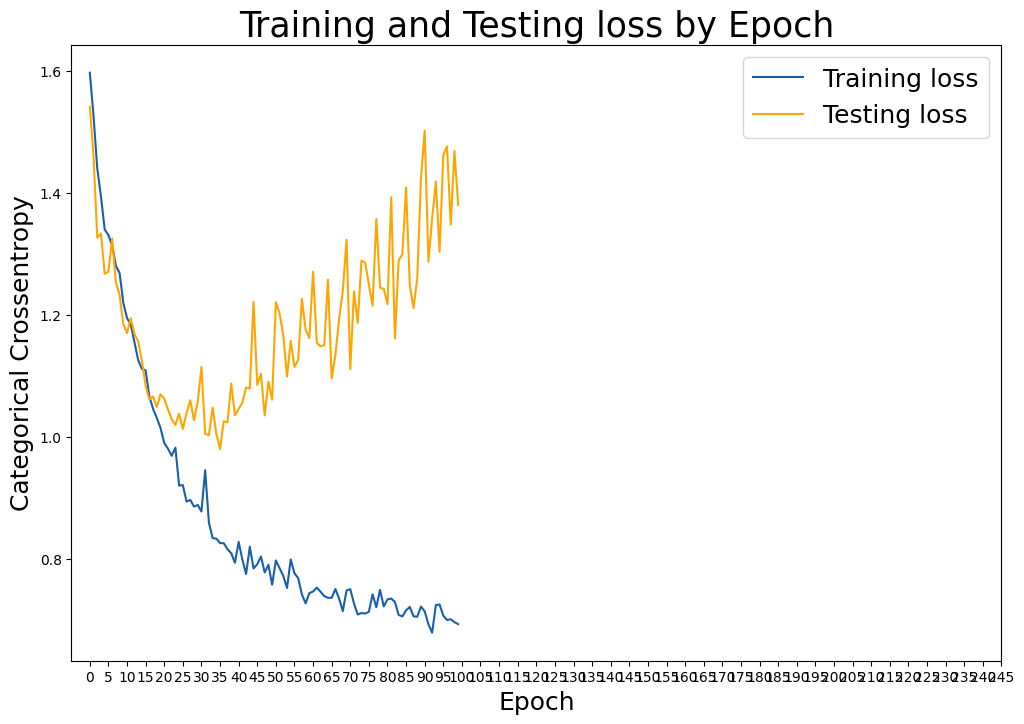

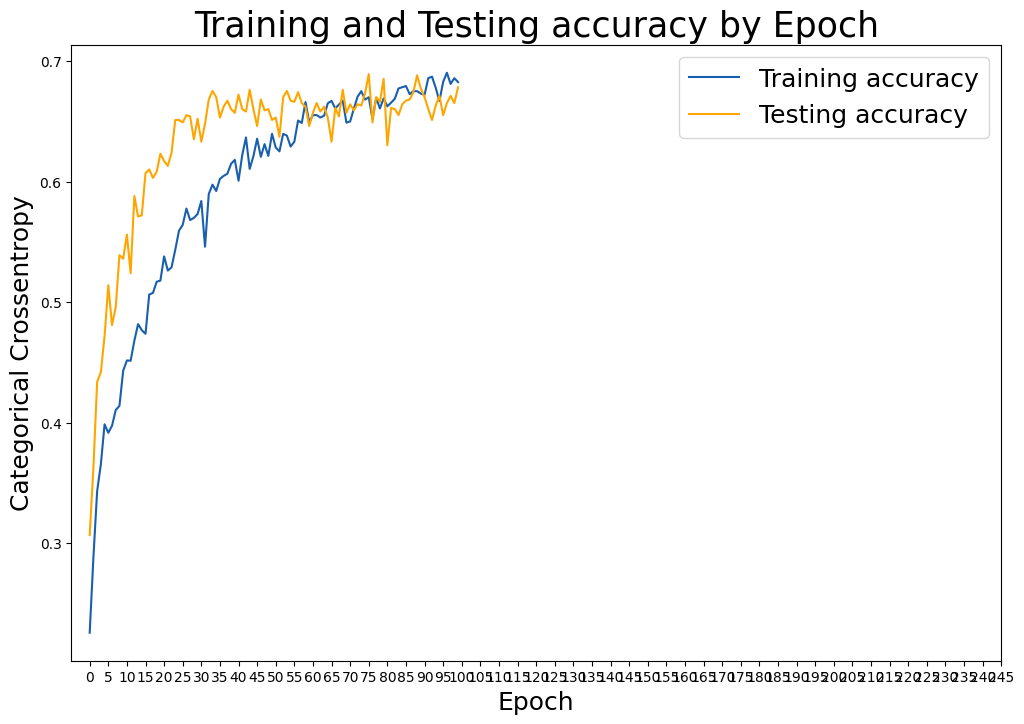

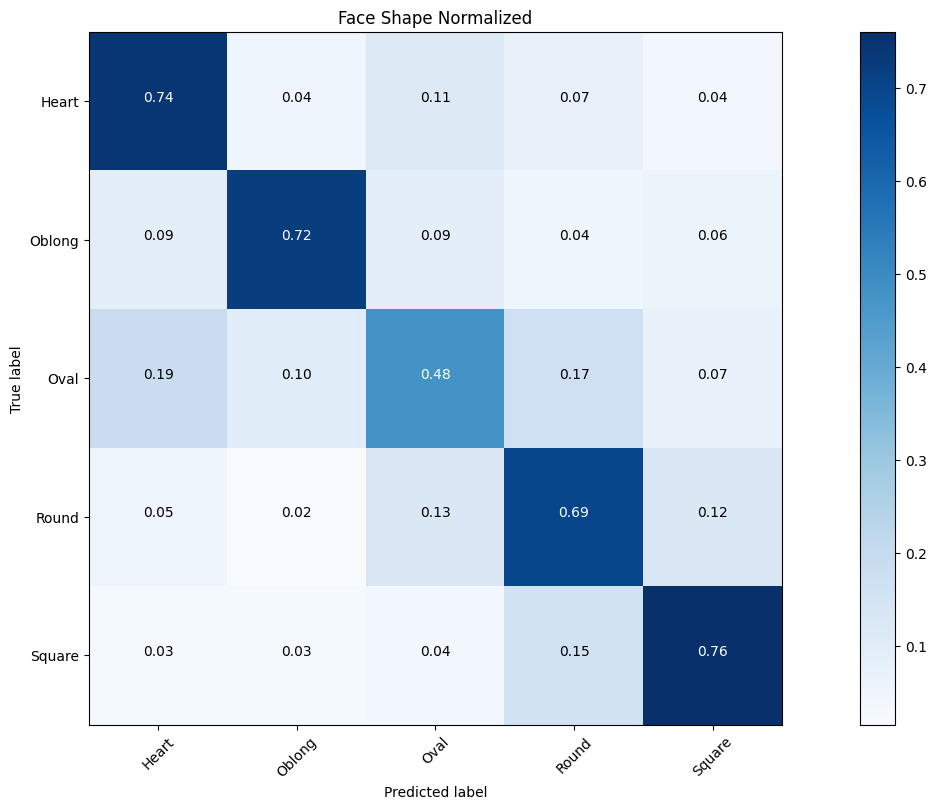

In [14]:
plot_summary_results(model, history, 250)

In [24]:
model_path = './saved_face_models/'
filename = model_path + 'boxing_1.keras'

#tf.keras.models.save_model( 
#   model, filepath=model_path, overwrite=True, include_optimizer=True, save_format=None,
#   signatures='some_signatures', options='some_options')
 
model.save(filename, overwrite=True, include_optimizer=True)